In [13]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from dataset import dataset
from joblib import Parallel, delayed
#from neural_network import neural_net
from additional_functions import process_all
from additional_functions import save_arrays_to_csv
from additional_functions import load_arrays_from_csv
from additional_functions import make_plots_2

# Learning Algorithms

In [14]:
class backprop_nn:
    def __init__(self, data: dataset, prediction_type_flag: str, hidden_layer_count=0, network_shape=[], hidden_node_count=1, epochs=100, momentum=.9, learning_rate=.01, batch_size=10):
        self.epochs = epochs
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.hidden_layer_count = hidden_layer_count
        if hidden_layer_count == 0:
            hidden_node_count = 0
        else:
            hidden_node_count = [hidden_node_count] * hidden_layer_count
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag

        if self.prediction_type == "classification":
            self.class_count = len(np.unique(self.tune_set[:,-1]))
        else:
            self.class_count = 0

        input_size = self.tune_set.shape[1] - 1
        self.input_size = input_size
        if network_shape == []:
            self.network_shape = [input_size] + (hidden_node_count if hidden_node_count else []) + ([self.class_count] if (self.prediction_type == "classification") else [1])
        else:
            self.network_shape = network_shape
        self.biases = []
        self.weights = []
        self.bias_velocity = []
        self.weight_velocity = []
    def init_weights_biases_momentum(self):
        '''
        Initializes weights randomly based on the network shape list
        '''
        self.biases = [np.random.randn(next_size, 1) for next_size in self.network_shape[1:]]
        self.weights = [np.random.randn(next_size, cur_size) for cur_size, next_size in zip(self.network_shape[:-1], self.network_shape[1:])]
        self.bias_velocity = [np.zeros(bias.shape) for bias in self.biases]
        self.weight_velocity = [np.zeros(weight.shape) for weight in self.weights]
    def for_prop(self, input: np):
        '''
        Feeds forward a single example through the network
        '''
        output = input
        for bias, weight in zip(self.biases[:-1], self.weights[:-1]):
            output = self.sigmoid(np.dot(weight, output) + bias)        #for each weight calculate the output of the activation function
                
        bias, weight = self.biases[-1], self.weights[-1]
        #For regression, use a linear combination for output activation
        #For classification, use a softmax output activation
        output = (np.dot(weight, output) + bias)    
        if self.prediction_type == "classification":
            output = self.softmax(output)
        return output
    def get_training_data(self, i: int):
        '''
        method needs to take in training data and compile 9 of the 10 folds (not fold I) into an array
        we then want to format the data as follows: each example = (attributes, label)
        I is used to indicate which fold is the hold out fold
        '''
        desired_data = np.concatenate([self.validate_set[j] for j in range(10) if j != i])  #Get all folds other than fold I and compile into its own array
        training_data = [(example[:-1], example[-1]) for example in desired_data]   #Format properly
        return training_data
    def get_testing_data(self, i: int):
        '''
        method needs to take in training data and compile 1 of the 10 folds (fold I) into an array
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = self.validate_set[i]         #Get the test set
        testing_data = [(example[:-1], example[-1]) for example in desired_data] #Format properly
        return testing_data
    def get_tuning_data(self):
        '''
        method needs to take in the tuning set and properly format it
        Then format the data as follows: each example = (attributes, label)
        i is used to indicate which training set you want returned
        '''
        desired_data = self.tune_set  #Get the tuning set
        tuning_data = [(example[:-1], example[-1]) for example in desired_data] #Format properly
        return tuning_data
    def grad_desc(self, training_data, epochs, momentum, learning_rate, batch_size):
        # ***THINK OF THIS METHOD AS TRAINING VIA BACKPROPOGATION*** #
        '''
        Takes in a traing set from get_training_data. The format is a list of tuples, where each tuple
        represents an example. Within each tuple the first value is the feature vector and the second
        value is the label.

        We want to complete mini batch gradient descent

        This method effectively trains the model
        '''
        example_count = len(training_data)
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+batch_size] for k in range(0, example_count, batch_size)]         #Form the mini batches based on the batch size hyperparameters
            for mini_batch in mini_batches:
                self.update_weights(mini_batch, momentum, learning_rate)                                        #for each mini batch, update the weights
    def update_weights(self, mini_batch, momentum, learning_rate):
        '''
        This method takes in a mini batch and the momentum and learning rate hyperparameters. It needs to compute the gradient
        for the biases and the weights, use the gradients to calculate the velocities, and use the velocities to update the weights
        and biases.
        '''
        bias_gradient = [np.zeros(bias.shape) for bias in self.biases]          #initialize an empty array to store the gradients
        weight_gradient = [np.zeros(weight.shape) for weight in self.weights]

        # Compute gradients for the mini-batch
        for feature, label in mini_batch:           
            if not np.isnan(label):
                delta_bias_gradient, delta_weight_gradient = self.epoch(feature, label)
                bias_gradient = [gradient + delta for gradient, delta in zip(bias_gradient, delta_bias_gradient)]
                weight_gradient = [gradient + delta for gradient, delta in zip(weight_gradient, delta_weight_gradient)]
        
        # Update velocities and apply updates with momentum
        self.bias_velocity = [momentum * velocity - (learning_rate / len(mini_batch)) * gradient for velocity, gradient in zip(self.bias_velocity, bias_gradient)]
        self.weight_velocity = [momentum * velocity - (learning_rate / len(mini_batch)) * gradient for velocity, gradient in zip(self.weight_velocity, weight_gradient)]

        # Update weights and biases
        self.biases = [bias + velocity for bias, velocity in zip(self.biases, self.bias_velocity)]
        self.weights = [bias + velocity for bias, velocity in zip(self.weights, self.weight_velocity)]
    def epoch(self, feature, label):
        '''
        This method should complete one full cycle of forward propogation, loss calculation, calculate gradients based on loss
        and back propogation to update weights. 
        '''
        
        bias_gradient = [np.zeros(bias.shape) for bias in self.biases]
        weight_gradient = [np.zeros(weight.shape) for weight in self.weights]
        #forprop
        activation = feature
        activations = [feature] # list to store all the activations
        weighted_inputs = []
        for bias, weight in zip(self.biases[:-1], self.weights[:-1]):
            weighted_input = np.dot(weight, activation.reshape(-1,1)) + bias
            activation = self.sigmoid(weighted_input)
            weighted_inputs.append(weighted_input)
            activations.append(activation)
        # The output layer uses different activation functions
        bias, weight = self.biases[-1], self.weights[-1]
        weighted_input = np.dot(weight, activation.reshape(-1,1)) + bias
        #weighted_input = np.dot(weight, activation)
        activation = weighted_input
        if self.prediction_type == "classification":
            activation = self.softmax(weighted_input)
        weighted_inputs.append(weighted_input)
        activations.append(activation)

    


        # backprop
       
        if self.prediction_type == "classification":
            one_hot_label = [0] * self.class_count
            one_hot_label[int(label)] = 1
            one_hot_label = np.array(one_hot_label).reshape(-1, 1)
        else:
            one_hot_label = label       
        delta = (activations[-1] - one_hot_label) # * self.softmax(weighted_inputs[-1])
        bias_gradient[-1] = delta
        
        weight_gradient[-1] = np.dot(delta, activations[-2].reshape(1,-1))

        for layer_idx in range(2, len(self.network_shape)):
            weighted_input = weighted_inputs[-layer_idx]
            activation_prime = self.sigmoid_prime(weighted_input)
            delta = np.dot(self.weights[-layer_idx+1].transpose(), delta) * activation_prime
            
            if delta.shape == (1,1):
                bias_gradient[-layer_idx] = delta.reshape(-1)
                weight_gradient[-layer_idx] = (delta.reshape(-1) * activations[-layer_idx-1].transpose())
            else:
                bias_gradient[-layer_idx] = delta
                weight_gradient[-layer_idx] = np.dot(delta, activations[-layer_idx-1].reshape(1,-1))       
        return (bias_gradient, weight_gradient)
    def tune(self):
        '''
        The method should test the hyperparameter values below and return the combination of hyperparameters
        that result in the best performance for the algorithm.
        '''
        hidden_node_vals = [1, 3, 5, 7, 9]
        epoch_vals = [10, 50, 100, 200, 500]
        momentum_vals = [0.5, 0.7, 0.9, 0.95, 0.99]
        learning_rate_vals = [0.0001, 0.001, 0.01, 0.1, 1.0]
        batch_size_vals = [16, 32, 64, 128, 256]

        hidden_node_scores = []
        epoch_scores = []
        momentum_scores = []
        learning_rate_scores = []
        batch_size_scores = []

        # Hidden node Count Tuning
        '''
        If there is only one hidden layer try all five possible values and return the values that leads to best performance
        If there are two hiddens layers complete a grid search with the five possible values and return the combination that performs the best
        '''
        if (self.hidden_layer_count > 0):       #skip if there are no hidden layers
            hidden_node_combinations = list(itertools.product(hidden_node_vals, repeat=self.hidden_layer_count))
            for combination in tqdm(hidden_node_combinations, desc="Tuning Hidden Node Count", leave=False):
                self.network_shape = [self.input_size] + (list(combination)) + ([self.class_count] if (self.prediction_type == "classification") else [1])
                hidden_node_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
                hidden_node_scores.append(np.mean(hidden_node_score))
            hidden_node_scores = np.array(hidden_node_scores)
            if self.prediction_type == "classification":
                self.network_shape = [self.input_size] + (list(hidden_node_combinations[np.argmax(hidden_node_scores)])) + ([self.class_count] if (self.prediction_type == "classification") else [1])
            else:
                self.network_shape = [self.input_size] + (list(hidden_node_combinations[np.argmin(hidden_node_scores)])) + ([self.class_count] if (self.prediction_type == "classification") else [1])          
            print(f"Tuned Network Shape: {self.network_shape}")

        # Epoch tuning
        #Test all five epoch values above and return the value that performs the best
        for epochs in tqdm(epoch_vals, desc="Tuning Epochs", leave=False):
            epoch_score = self.train_test(tuning_flag=True, epochs=epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
            epoch_scores.append(np.mean(epoch_score))
        epoch_scores = np.array(epoch_scores)
        if self.prediction_type == "classification":
            self.epochs = epoch_vals[np.argmax(epoch_scores)]
        else:
            self.epochs = epoch_vals[np.argmin(epoch_scores)]
        print(f"Tuned Epoch Value: {self.epochs}")

        # Momentum Tuning
        #Try all five momentum values and return the value that performs the best
        for momentum in tqdm(momentum_vals, desc="Tuning Momentum", leave=False):
            momentum_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=momentum, learning_rate=self.learning_rate, batch_size=self.batch_size)
            momentum_scores.append(np.mean(momentum_score))
        momentum_scores = np.array(momentum_scores)
        if self.prediction_type == "classification":
            self.momentum = momentum_vals[np.argmax(momentum_scores)]
        else:
            self.momentum = momentum_vals[np.argmin(momentum_scores)]
        print(f"Tuned Momentum Value: {self.momentum}")

        # Learning rate tuning
        #Try all five learning rate values and return the value that performs the best
        for learning_rate in tqdm(learning_rate_vals, desc="Tuning Learning Rate", leave=False):
            learning_rate_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=learning_rate, batch_size=self.batch_size)
            learning_rate_scores.append(np.mean(learning_rate_score))
        learning_rate_scores = np.array(learning_rate_scores)
        if self.prediction_type == "classification":
            self.learning_rate = learning_rate_vals[np.argmax(learning_rate_scores)]
        else:
            self.learning_rate = learning_rate_vals[np.argmin(learning_rate_scores)]
        print(f"Tuned Learning Rate: {self.learning_rate}")

        # Batch size tuning
        #Try all five momentum values and return the value that performs the best
        for batch_size in tqdm(batch_size_vals, desc="Tuning Batch Size", leave=False):
            batch_size_score = self.train_test(tuning_flag=True, epochs=self.epochs, momentum=self.momentum, learning_rate=self.learning_rate, batch_size=batch_size)
            batch_size_scores.append(np.mean(batch_size_score))
        batch_size_scores = np.array(batch_size_scores)
        if self.prediction_type == "classification":
            self.batch_size = batch_size_vals[np.argmax(batch_size_scores)]
        else:
            self.batch_size = batch_size_vals[np.argmin(batch_size_scores)]
        print(f"Tuned Batch Size: {self.batch_size}")

        return [self.network_shape, self.epochs, self.momentum, self.learning_rate, self.batch_size]
    def train_test(self, tuning_flag: bool, epochs=100, momentum=.9, learning_rate=.01, batch_size=10):
        '''
        This method should take in the hyperparameters determined during tuning. It should use those hyperparameter
        values to train and test the model and return the calculated loss scores
        '''
        scores = []
        if tuning_flag:
            for i in range(10):
                self.init_weights_biases_momentum()     
                self.grad_desc(self.get_training_data(i), epochs, momentum, learning_rate, batch_size)
                score = self.loss(self.get_tuning_data())
                scores.append(score)
        else:
            for i in tqdm(range(10), desc="Evaluating Test Data", leave=False):
                self.init_weights_biases_momentum()
                self.grad_desc(self.get_training_data(i), self.epochs, self.momentum, self.learning_rate, self.batch_size)
                score = self.loss(self.get_testing_data(i))
                scores.append(score)
        return np.array(scores)
    def loss(self, test_data):
        '''
        This method calculates the loss based on our evaluation metrics
        For classification: 0/1 loss
        For regression: Mean squared error
        '''
        if self.prediction_type == "classification":
            results = [(np.argmax(self.for_prop(example)), label) for (example, label) in test_data if not np.isnan(label)]
            correct_results = sum(int(example == label) for (example, label) in results)
            total_examples = len(results)
            return correct_results / total_examples
        else:
            results = [(self.for_prop(x), y) for (x, y) in test_data if not np.isnan(y)]
            # Ensure predictions and labels are both 1D arrays of the same length
            predictions = np.array([prediction.flatten()[0] if prediction.size == 1 else np.argmax(prediction) for (prediction, label) in results], dtype=float)
            labels = np.array([label for (prediction, label) in results], dtype=float)

            # Calculate MSE
            mse = np.mean((predictions - labels) ** 2)
            return mse
    def sigmoid(self, input: np):       #used the logistic function as our activation
        return 1.0/(1.0+np.exp(-input))
    def sigmoid_prime(self, input: np): #derivative of the logistic function
        return self.sigmoid(input)*(1-self.sigmoid(input))
    def softmax(self, input):   #softmax for output activation during classification
        exp = np.exp(input - np.max(input))
        return exp / np.sum(exp)    

In [15]:
class DE_nn(backprop_nn):
    def __init__(self, data: dataset, prediction_type_flag: str, network_shape: list, population_size=50, epochs=100, scaling_factor=0.7, crossover_rate=0.7):
        self.epochs = epochs
        self.pop_size = population_size
        self.f = scaling_factor
        self.cr = crossover_rate
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag

        if self.prediction_type == "classification":
            self.class_count = len(np.unique(self.tune_set[:,-1]))
        else:
            self.class_count = 0
            
        input_size = self.tune_set.shape[1] - 1
        self.input_size = input_size
        self.network_shape = network_shape
        self.population = []
        self.model = ()
    def init_population(self, pop_size):
        '''
        Initializes a population of weights and biases
        '''
        self.population = []
        for i in range(pop_size):
            biases = [np.random.randn(next_size, 1) for next_size in self.network_shape[1:]]
            weights = [np.random.randn(next_size, cur_size) for cur_size, next_size in zip(self.network_shape[:-1], self.network_shape[1:])]
            self.population.append((weights,biases))
    def donor_vector(self, f):
        # Step 1: Select 3 candidates
        candidates = random.sample(self.population,3)
        # Step 2: For each candidate, mutate the weights and biases
        weights_1, biases_1 = candidates[0]
        weights_2, biases_2 = candidates[1]
        weights_3, biases_3 = candidates[2]
        new_weights = []
        new_biases = []

        for w1, w2, w3 in zip(weights_1, weights_2, weights_3):
            new_weight = w1 + f * (w2 - w3)
            new_weights.append(new_weight)

        # Apply the equation for each bias vector
        for b1, b2, b3 in zip(biases_1, biases_2, biases_3):
            new_bias = b1 + f * (b2 - b3)
            new_biases.append(new_bias)

        # Return the donor vector (weights, biases)
        return (new_weights, new_biases)
    def trial_vector(self, target_candidate, f, cr):
        # Unpack target candidate and donor vector
        target_weights, target_biases = target_candidate
        donor_vector = self.donor_vector(f)
        donor_weights, donor_biases = donor_vector

        # Initialize lists to store trial weights and biases
        trial_weights = []
        trial_biases = []

        # Apply crossover to weights
        for target_weight, donor_weight in zip(target_weights, donor_weights):
            # Perform element-wise crossover
            mask = np.random.rand(*target_weight.shape) < cr
            trial_weight = np.where(mask, donor_weight, target_weight)
            trial_weights.append(trial_weight)

        # Apply crossover to biases
        for target_bias, donor_bias in zip(target_biases, donor_biases):
            # Perform element-wise crossover
            mask = np.random.rand(*target_bias.shape) < cr
            trial_bias = np.where(mask, donor_bias, target_bias)
            trial_biases.append(trial_bias)

        # Return the trial vector (weights, biases)
        return (trial_weights, trial_biases)
    def evaluate_fitness(self, test_data, target, trial):
        '''
        Returns the best performing model between the target and trial
        '''
        target_fitness = self.loss(test_data, target)
        trial_fitness = self.loss(test_data, trial)
        if self.prediction_type == "classification":
            if max(target_fitness, trial_fitness) == target_fitness:
                return target
            else:
                return trial
        else:
            if min(target_fitness, trial_fitness) == target_fitness:
                return target
            else:
                return trial
    def for_prop(self, input: np, weights, biases):
        '''
        Feeds forward a single example through the network
        '''
        output = input
        for bias, weight in zip(biases[:-1], weights[:-1]):
            output = self.sigmoid(np.dot(weight, output) + bias)        #for each weight calculate the output of the activation function
                
        bias, weight = biases[-1], weights[-1]
        #For regression, use a linear combination for output activation
        #For classification, use a softmax output activation
        output = (np.dot(weight, output) + bias)    
        if self.prediction_type == "classification":
            output = self.softmax(output)
        return output
    def loss(self, test_data, model):
        '''
        This method calculates the loss based on our evaluation metrics
        For classification: 0/1 loss
        For regression: Mean squared error
        '''
        weights, biases = model
        if self.prediction_type == "classification":
            results = [(np.argmax(self.for_prop(example, weights, biases)), label) for (example, label) in test_data if not np.isnan(label)]
            correct_results = sum(int(example == label) for (example, label) in results)
            total_examples = len(results)
            return correct_results / total_examples
        else:
            results = [(self.for_prop(x, weights, biases), y) for (x, y) in test_data if not np.isnan(y)]
            # Ensure predictions and labels are both 1D arrays of the same length
            predictions = np.array([prediction.flatten()[0] if prediction.size == 1 else np.argmax(prediction) for (prediction, label) in results], dtype=float)
            labels = np.array([label for (prediction, label) in results], dtype=float)

            # Calculate MSE
            mse = np.mean((predictions - labels) ** 2)
            return mse
    def best_candidate(self, test_data):
        '''
        Returns the best model among a population
        '''
        scores = []
        for candidate in self.population:
            scores.append(self.loss(test_data, candidate))
        scores = np.array(scores)
        if self.prediction_type == "classification":
            return self.population[np.argmax(scores)]
        else:
            return self.population[np.argmin(scores)]
    def evolve(self, test_data, epochs, f, cr):
        '''
        This method evolves the models in the population
        '''
        for i in range(epochs):
            new_population = []
            for candidate in self.population:
                trial_vector = self.trial_vector(candidate, f, cr)
                new_candidate = self.evaluate_fitness(test_data, candidate, trial_vector)
                new_population.append(new_candidate)
            self.population = new_population
        self.model = self.best_candidate(test_data)
    def train_test(self, tuning_flag: bool, pop_size=50, epochs=100, f=0.7, cr=0.5):
        '''
        This method should take in the hyperparameters determined during tuning. It should use those hyperparameter
        values to train and test the model and return the calculated loss scores.
        '''

        # Define a function that encapsulates the work for each iteration
        def train_single_model(i):
            # Use self to access methods and attributes from the class
            if tuning_flag:
                self.init_population(pop_size)
                self.evolve(self.get_training_data(i), epochs, f, cr)
            else:
                self.init_population(self.pop_size)
                self.evolve(self.get_training_data(i), self.epochs, self.f, self.cr)
            return self.loss(self.get_tuning_data() if tuning_flag else self.get_testing_data(i), self.model)

        # Parallel execution using joblib
        scores = Parallel(n_jobs=12)(
            delayed(train_single_model)(i)
            for i in tqdm(range(10), desc="Evaluating Models", leave=False)
        )
        return np.array(scores)
    def tune(self, tuning_pop_size=False, tuning_epochs=True, tuning_f=True, tuning_cr=True):
        '''
        Four parameters need to be tuned: Population size, epochs, scaling factor, crossover rate
        '''
        pop_size_vals = [10, 50, 100, 200]
        epoch_vals = [10, 50, 100, 200, 500]
        f_vals = [0.4, 0.5, 0.7, 0.9, 1.0]
        cr_vals = [0.1, 0.3, 0.5, 0.7, 0.9]

        pop_size_scores = []
        epoch_scores = []
        f_scores = []
        cr_scores = []

        if tuning_pop_size:
            # Population Size Tuning
            #Try all four pop size values and return the value that performs the best
            for pop_size in tqdm(pop_size_vals, desc="Tuning Population Size", leave=False):
                pop_size_score = self.train_test(tuning_flag=True, pop_size=pop_size, epochs=self.epochs, f=self.f, cr=self.cr)
                pop_size_scores.append(np.mean(pop_size_score))
            pop_size_scores = np.array(pop_size_scores)
            if self.prediction_type == "classification":
                self.pop_size = pop_size_vals[np.argmax(pop_size_scores)]
            else:
                self.pop_size = pop_size_vals[np.argmin(pop_size_scores)]
            print(f"Tuned Population Size: {self.pop_size}")
        
        if tuning_epochs:
            # Epoch Tuning
            #Try all five epoch values and return the value that performs the best
            for epoch in tqdm(epoch_vals, desc="Tuning Epochs", leave=False):
                epoch_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=epoch, f=self.f, cr=self.cr)
                epoch_scores.append(np.mean(epoch_score))
            epoch_scores = np.array(epoch_scores)
            if self.prediction_type == "classification":
                self.epochs = epoch_vals[np.argmax(epoch_scores)]
            else:
                self.epochs = epoch_vals[np.argmin(epoch_scores)]
            print(f"Tuned Epoch Value: {self.epochs}")

        if tuning_f:
            # Scaling Factor Tuning
            #Try all five epoch values and return the value that performs the best
            for f in tqdm(f_vals, desc="Tuning Scaling Factor", leave=False):
                f_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=self.epochs, f=f, cr=self.cr)
                f_scores.append(np.mean(f_score))
            f_scores = np.array(f_scores)
            if self.prediction_type == "classification":
                self.f = f_vals[np.argmax(f_scores)]
            else:
                self.f = f_vals[np.argmin(f_scores)]
            print(f"Tuned Scaling Factor: {self.f}")

        if tuning_cr:
            # Crossover Rate Tuning
            #Try all five epoch values and return the value that performs the best
            for cr in tqdm(cr_vals, desc="Tuning Crossover Rate", leave=False):
                cr_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=self.epochs, f=self.f, cr=cr)
                cr_scores.append(np.mean(cr_score))
            cr_scores = np.array(cr_scores)
            if self.prediction_type == "classification":
                self.cr = cr_vals[np.argmax(cr_scores)]
            else:
                self.cr = cr_vals[np.argmin(cr_scores)]
            print(f"Tuned Crossover Rate: {self.cr}")


        return [self.pop_size, self.epochs, self.f, self.cr]

In [ ]:
class GA_nn(DE_nn):
    def __init__(self, data: dataset, prediction_type_flag: str, network_shape: list, population_size=50, epochs=100, selection_size=0.4, mutation_rate=0.05, crossover_rate=0.5):
        self.pop_size = population_size
        self.epochs = epochs
        self.select_size = selection_size
        self.mr = mutation_rate
        self.cr = crossover_rate
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag

        if self.prediction_type == "classification":
            self.class_count = len(np.unique(self.tune_set[:,-1]))
        else:
            self.class_count = 0
            
        input_size = self.tune_set.shape[1] - 1
        self.input_size = input_size
        self.network_shape = network_shape
        self.population = []
        self.model = ()
    def select_candidates(self, test_data, select_size):
        '''
        Returns the best and worst 'select_size' models among the population
        '''
        # Evaluate all candidates
        scores = []
        for candidate in self.population:
            scores.append(self.loss(test_data, candidate))
        scores = np.array(scores)
        
        # Sort candidates based on prediction type (classification or regression)
        if self.prediction_type == "classification":
            # For classification, higher scores are better
            sorted_indices = scores.argsort()[::-1]  # Sort in descending order
        else:
            # For regression, lower scores are better
            sorted_indices = scores.argsort()  # Sort in ascending order

        # Select the top 'select_size' candidates
        top_indices = sorted_indices[:select_size]
        top_candidates = [self.population[i] for i in top_indices]

        # Select the bottom 'select_size' candidates
        bottom_indices = sorted_indices[-select_size:]
        bottom_candidates = [self.population[i] for i in bottom_indices]

        return top_candidates, bottom_candidates
    def crossover(self, candidates, cr):

        new_candidates = []

        for i in range(0, len(candidates), 2):
            # Initialize lists to store trial weights and biases
            weights = []
            biases = []

            # Access the current pair of items
            parent_1 = candidates[i]
            if i + 1 < len(candidates):
                parent_2 = candidates[i + 1]
            parent_1_weights, parent_1_biases = parent_1
            parent_2_weights, parent_2_biases = parent_2

            # Apply crossover to weights
            for parent_1_weight, parent_2_weight in zip(parent_1_weights, parent_2_weights):
                # Perform element-wise crossover
                mask = np.random.rand(*parent_1_weight.shape) < cr
                weight = np.where(mask, parent_2_weight, parent_1_weight)
                weights.append(weight)

            # Apply crossover to biases
            for parent_1_bias, parent_2_bias in zip(parent_1_biases, parent_2_biases):
                # Perform element-wise crossover
                mask = np.random.rand(*parent_1_bias.shape) < cr
                bias = np.where(mask, parent_2_bias, parent_1_bias)
                biases.append(bias)
            
            new_candidates.append((weights,biases))

        # Return the crossed-over candidates
        return new_candidates   
    def mutate(self, candidates, mr):
        '''
        Mutates the weights and biases of the candidates based on a given mutation probability.
        Args:
        - candidates: List of candidates, where each candidate is a tuple (weights, biases).
        - mutation_prob: Probability of mutation for each weight and bias (float between 0 and 1).

        Returns:
        - mutated_candidates: List of mutated candidates.
        '''
        mutated_candidates = []

        # Iterate over all candidates
        for weights, biases in candidates:
            # Create new lists to store mutated weights and biases
            new_weights = []
            new_biases = []

            # Iterate over each weight array in the candidate
            for weight in weights:
                if np.random.rand() < mr:
                    # Mutate weight by adding a small random noise
                    mutated_weight = weight + np.random.normal(0, 0.1, size=weight.shape)
                else:
                    # No mutation, keep original weight
                    mutated_weight = weight
                new_weights.append(mutated_weight)

            # Iterate over each bias array in the candidate
            for bias in biases:
                if np.random.rand() < mr:
                    # Mutate bias by adding a small random noise
                    mutated_bias = bias + np.random.normal(0, 0.1, size=bias.shape)
                else:
                    # No mutation, keep original bias
                    mutated_bias = bias
                new_biases.append(mutated_bias)

            # Append the mutated candidate to the new list
            mutated_candidates.append((new_weights, new_biases))

        return mutated_candidates
    def selection(self, test_data, select_size, mr, cr):
        '''
        Returns a new population of equal size to the original, with replaced candidates
        that have been through tournament, crossover, and mutation.
        '''
        # Function to check if two tuples containing lists of numpy arrays are equal
        def are_tuples_equal(tuple1, tuple2):
            list1_weights, list1_biases = tuple1
            list2_weights, list2_biases = tuple2
            # Check if all weight arrays are equal
            if len(list1_weights) != len(list2_weights) or len(list1_biases) != len(list2_biases):
                return False
            for w1, w2 in zip(list1_weights, list2_weights):
                if not np.array_equal(w1, w2):
                    return False
            # Check if all bias arrays are equal
            for b1, b2 in zip(list1_biases, list2_biases):
                if not np.array_equal(b1, b2):
                    return False
            return True

        # Step 1: Select X best and X worst candidates
        top_candidates, bottom_candidates = self.select_candidates(test_data, select_size)
        # Step 2: Crossover the best candidates
        new_candidates = self.crossover(top_candidates, cr)
        # Step 3: Mutate the best candidates
        new_candidates = self.mutate(new_candidates, mr)
        # Step 4: Replace the X worst candidates with the new candidates
        new_population = []
        # Iterate over list_c and replace matching items with the corresponding item from list_b
        for candidate in self.population:
            found_match = False
            # Check if item matches anything in list_a
            for i, bottom_candidate in enumerate(bottom_candidates):
                if are_tuples_equal(candidate, bottom_candidate):
                    # Replace with the corresponding item in list_b
                    new_population.append(top_candidates[i])
                    found_match = True
                    break
            if not found_match:
                # If no match, keep the original item
                new_population.append(candidate)
        return new_population
    def evolve(self, test_data, epochs, select_size, mr, cr):
        for i in range(epochs):
            new_population = self.selection(test_data, select_size, mr, cr)
            self.population = new_population
        self.model = self.best_candidate(test_data)
    def train_test(self, tuning_flag: bool, pop_size=50, epochs=100, select_size=0.4, mr=0.05, cr=0.5):
        '''
        This method should take in the hyperparameters determined during tuning. It should use those hyperparameter
        values to train and test the model and return the calculated loss scores.
        '''

        # Define a function that encapsulates the work for each iteration
        def train_single_model(i):
            # Use self to access methods and attributes from the class
            if tuning_flag:
                self.init_population(pop_size)
                self.evolve(self.get_training_data(i), epochs, select_size, mr, cr)
            else:
                self.init_population(self.pop_size)
                self.evolve(self.get_training_data(i), self.epochs, int(self.select_size*self.pop_size), self.mr, self.cr)
            return self.loss(self.get_tuning_data() if tuning_flag else self.get_testing_data(i), self.model)

        # Parallel execution using joblib
        scores = Parallel(n_jobs=12)(
            delayed(train_single_model)(i)
            for i in tqdm(range(10), desc="Evaluating Models", leave=False)
        )
        return np.array(scores)
    def tune(self, tuning_pop_size=False, tuning_epochs=True, tuning_select_size=True, tuning_mr=True, tuning_cr=True):
        '''
        Five parameters need to be tuned: Population size, epochs, selection size, mutation rate, crossover rate
        '''
        pop_size_vals = [10, 50, 100, 200]
        epoch_vals = [10, 50, 100, 200, 500]
        select_size_vals = [0.2, 0.4, 0.6, 0.8]
        mr_vals = [0.01, 0.03, 0.05, 0.07, 0.1]
        cr_vals = [0.1, 0.3, 0.5, 0.7, 0.9]

        pop_size_scores = []
        epoch_scores = []
        select_size_scores = []
        mr_scores = []
        cr_scores = []

        if tuning_pop_size:
            # Population Size Tuning
            #Try all four pop size values and return the value that performs the best
            for pop_size in tqdm(pop_size_vals, desc="Tuning Population Size", leave=False):
                pop_size_score = self.train_test(tuning_flag=True, pop_size=pop_size, epochs=self.epochs, select_size=int(self.select_size*pop_size), mr=self.mr, cr=self.cr)
                pop_size_scores.append(np.mean(pop_size_score))
            pop_size_scores = np.array(pop_size_scores)
            if self.prediction_type == "classification":
                self.pop_size = pop_size_vals[np.argmax(pop_size_scores)]
            else:
                self.pop_size = pop_size_vals[np.argmin(pop_size_scores)]
            print(f"Tuned Population Size: {self.pop_size}")
        
        if tuning_epochs:
            # Epoch Tuning
            #Try all five epoch values and return the value that performs the best
            for epoch in tqdm(epoch_vals, desc="Tuning Epochs", leave=False):
                epoch_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=epoch, select_size=int(self.select_size*self.pop_size), mr=self.mr, cr=self.cr)
                epoch_scores.append(np.mean(epoch_score))
            epoch_scores = np.array(epoch_scores)
            if self.prediction_type == "classification":
                self.epochs = epoch_vals[np.argmax(epoch_scores)]
            else:
                self.epochs = epoch_vals[np.argmin(epoch_scores)]
            print(f"Tuned Epoch Value: {self.epochs}")

        if tuning_select_size:
            # Scaling Factor Tuning
            #Try all five epoch values and return the value that performs the best
            for select_size in tqdm(select_size_vals, desc="Tuning Selection Size", leave=False):
                select_size_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=self.epochs, select_size=int(select_size*self.pop_size), mr=self.mr, cr=self.cr)
                select_size_scores.append(np.mean(select_size_score))
            select_size_scores = np.array(select_size_scores)
            if self.prediction_type == "classification":
                self.select_size = select_size_vals[np.argmax(select_size_scores)]
            else:
                self.select_size = select_size_vals[np.argmin(select_size_scores)]
            print(f"Tuned Selection Size: {self.select_size}")

        if tuning_mr:
            # Crossover Rate Tuning
            #Try all five epoch values and return the value that performs the best
            for mr in tqdm(mr_vals, desc="Tuning Mutation Rate", leave=False):
                mr_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=self.epochs, select_size=int(self.select_size*self.pop_size), mr=mr, cr=self.cr)
                mr_scores.append(np.mean(mr_score))
            mr_scores = np.array(mr_scores)
            if self.prediction_type == "classification":
                self.mr = mr_vals[np.argmax(mr_scores)]
            else:
                self.mr = mr_vals[np.argmin(mr_scores)]
            print(f"Tuned Mutation Rate: {self.mr}")

        if tuning_cr:
            # Crossover Rate Tuning
            #Try all five epoch values and return the value that performs the best
            for cr in tqdm(cr_vals, desc="Tuning Crossover Rate", leave=False):
                cr_score = self.train_test(tuning_flag=True, pop_size=self.pop_size, epochs=self.epochs, select_size=int(self.select_size*self.pop_size), mr=self.mr, cr=cr)
                cr_scores.append(np.mean(cr_score))
            cr_scores = np.array(cr_scores)
            if self.prediction_type == "classification":
                self.cr = cr_vals[np.argmax(cr_scores)]
            else:
                self.cr = cr_vals[np.argmin(cr_scores)]
            print(f"Tuned Crossover Rate: {self.cr}")


        return [self.pop_size, self.epochs, self.select_size, self.mr, self.cr]   

# Backpropogation NN Instantiation

In [17]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

In [18]:
# Classification Sets
cancer_back_0 = backprop_nn(cancer_data, "classification", hidden_layer_count=0, epochs=10,momentum=.5,learning_rate=.01,batch_size=16)
cancer_back_1 = backprop_nn(cancer_data, "classification", hidden_layer_count=1, network_shape=[9,1,2],epochs=50,momentum=.7,learning_rate=.1,batch_size=16)
cancer_back_2 = backprop_nn(cancer_data, "classification", hidden_layer_count=2, network_shape=[9,1,5,2],epochs=50,momentum=.9,learning_rate=.01,batch_size=16)

glass_back_0 = backprop_nn(glass_data, "classification", hidden_layer_count=0, epochs=100,momentum=.5,learning_rate=.001,batch_size=16)
glass_back_1 = backprop_nn(glass_data, "classification", hidden_layer_count=1, network_shape=[9,1,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)
glass_back_2 = backprop_nn(glass_data, "classification", hidden_layer_count=2, network_shape=[9,1,9,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)

soybean_back_0 = backprop_nn(soybean_data, "classification", hidden_layer_count=0, epochs=10,momentum=.99,learning_rate=.01,batch_size=16)
soybean_back_1 = backprop_nn(soybean_data, "classification", hidden_layer_count=1, network_shape=[35,1,4],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)
soybean_back_2 = backprop_nn(soybean_data, "classification", hidden_layer_count=2, network_shape=[35,1,9,4],epochs=500,momentum=.95,learning_rate=.1,batch_size=256)


# Regression Sets
abalone_back_0 = backprop_nn(abalone_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=32)
abalone_back_1 = backprop_nn(abalone_data, "regression", hidden_layer_count=1, network_shape=[8,1,1],epochs=500,momentum=.95,learning_rate=.01,batch_size=16)
abalone_back_2 = backprop_nn(abalone_data, "regression", hidden_layer_count=2, network_shape=[8,1,9,1],epochs=500,momentum=.99,learning_rate=.001,batch_size=16)

fire_back_0 = backprop_nn(fire_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=16)
fire_back_1 = backprop_nn(fire_data, "regression", hidden_layer_count=1, network_shape=[12,1,1],epochs=200,momentum=.95,learning_rate=.01,batch_size=16)
fire_back_2 = backprop_nn(fire_data, "regression", hidden_layer_count=2, network_shape=[12,1,1,1],epochs=500,momentum=.95,learning_rate=.001,batch_size=16)

machine_back_0 = backprop_nn(machine_data, "regression", hidden_layer_count=0, epochs=500,momentum=.95,learning_rate=.01,batch_size=16)
machine_back_1 = backprop_nn(machine_data, "regression", hidden_layer_count=1, network_shape=[9,1,1],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)
machine_back_2 = backprop_nn(machine_data, "regression", hidden_layer_count=2, network_shape=[9,1,7,1],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)

# Differential Evolution NN Instantiation

In [19]:
# def __init__(self, data: dataset, prediction_type_flag: str, network_shape: list, population_size=50, epochs=100, scaling_factor=0.7, crossover_rate=0.7):

# Classification Sets
cancer_DE_0 = DE_nn(cancer_data, "classification", network_shape=[9,2],epochs=200,scaling_factor=0.4,crossover_rate=0.9)
cancer_DE_1 = DE_nn(cancer_data, "classification", network_shape=[9,1,2],epochs=10,scaling_factor=0.5,crossover_rate=0.7)
cancer_DE_2 = DE_nn(cancer_data, "classification", network_shape=[9,1,5,2],epochs=200,scaling_factor=0.7,crossover_rate=0.9)

glass_DE_0 = DE_nn(glass_data, "classification", network_shape=[9,6],epochs=100,scaling_factor=0.4,crossover_rate=0.5)
glass_DE_1 = DE_nn(glass_data, "classification", network_shape=[9,1,6],epochs=500,scaling_factor=0.4,crossover_rate=0.1)
glass_DE_2 = DE_nn(glass_data, "classification", network_shape=[9,1,9,6],epochs=500,scaling_factor=0.4,crossover_rate=0.9)

soybean_DE_0 = DE_nn(soybean_data, "classification", network_shape=[35,4],epochs=500,scaling_factor=0.5,crossover_rate=0.3)
soybean_DE_1 = DE_nn(soybean_data, "classification", network_shape=[35,1,4],epochs=200,scaling_factor=0.5,crossover_rate=0.7)
soybean_DE_2 = DE_nn(soybean_data, "classification", network_shape=[35,1,9,4],epochs=500,scaling_factor=0.5,crossover_rate=0.5)


# Regression Sets
abalone_DE_0 = DE_nn(abalone_data, "regression", network_shape=[8,1],epochs=500,scaling_factor=0.4,crossover_rate=0.7)
abalone_DE_1 = DE_nn(abalone_data, "regression", network_shape=[8,1,1],epochs=500,scaling_factor=0.5,crossover_rate=0.9)
abalone_DE_2 = DE_nn(abalone_data, "regression", network_shape=[8,1,9,1],epochs=500,scaling_factor=0.4,crossover_rate=0.1)

fire_DE_0 = DE_nn(fire_data, "regression", network_shape=[12,1],epochs=500,scaling_factor=0.4,crossover_rate=0.7)
fire_DE_1 = DE_nn(fire_data, "regression", network_shape=[12,1,1],epochs=500,scaling_factor=0.7,crossover_rate=0.1)
fire_DE_2 = DE_nn(fire_data, "regression", network_shape=[12,1,1,1],epochs=50,scaling_factor=1.0,crossover_rate=0.3)

machine_DE_0 = DE_nn(machine_data, "regression", network_shape=[9,1],epochs=500,scaling_factor=0.7,crossover_rate=0.5)
machine_DE_1 = DE_nn(machine_data, "regression", network_shape=[9,1,1],epochs=100,scaling_factor=0.4,crossover_rate=0.9)
machine_DE_2 = DE_nn(machine_data, "regression", network_shape=[9,1,7,1],epochs=200,scaling_factor=0.4,crossover_rate=0.1)

# Genetic Algorithm NN Instantiation

In [20]:
# def __init__(population_size=50, epochs=100, selection_size=0.6, mutation_rate=0.5, crossover_rate=0.5):

# Classification Sets
cancer_GA_0 = GA_nn(cancer_data, "classification", network_shape=[9,2])
cancer_GA_1 = GA_nn(cancer_data, "classification", network_shape=[9,1,2])
cancer_GA_2 = GA_nn(cancer_data, "classification", network_shape=[9,1,5,2])

glass_GA_0 = GA_nn(glass_data, "classification", network_shape=[9,6])
glass_GA_1 = GA_nn(glass_data, "classification", network_shape=[9,1,6])
glass_GA_2 = GA_nn(glass_data, "classification", network_shape=[9,1,9,6])

soybean_GA_0 = GA_nn(soybean_data, "classification", network_shape=[35,4])
soybean_GA_1 = GA_nn(soybean_data, "classification", network_shape=[35,1,4])
soybean_GA_2 = GA_nn(soybean_data, "classification", network_shape=[35,1,9,4])


# Regression Sets
abalone_GA_0 = GA_nn(abalone_data, "regression", network_shape=[8,1])
abalone_GA_1 = GA_nn(abalone_data, "regression", network_shape=[8,1,1])
abalone_GA_2 = GA_nn(abalone_data, "regression", network_shape=[8,1,9,1])

fire_GA_0 = GA_nn(fire_data, "regression", network_shape=[12,1])
fire_GA_1 = GA_nn(fire_data, "regression", network_shape=[12,1,1])
fire_GA_2 = GA_nn(fire_data, "regression", network_shape=[12,1,1,1])

machine_GA_0 = GA_nn(machine_data, "regression", network_shape=[9,1])
machine_GA_1 = GA_nn(machine_data, "regression", network_shape=[9,1,1])
machine_GA_2 = GA_nn(machine_data, "regression", network_shape=[9,1,7,1])

# Genetic Algorithm Testing

## Cancer GA

In [22]:
cancer_GA_0_parameters = cancer_GA_0.tune()
cancer_GA_0_score = cancer_GA_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_GA_0_score)}")

Tuned Epoch Value: 50


Tuned Selection Size: 0.2


Tuned Mutation Rate: 0.03


Tuned Crossover Rate: 0.7


Average Performance: 0.7550179211469533


In [23]:
cancer_GA_1_parameters = cancer_GA_1.tune()
cancer_GA_1_score = cancer_GA_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_GA_1_score)}")

Tuned Epoch Value: 10


Tuned Selection Size: 0.6


Tuned Mutation Rate: 0.05


Tuned Crossover Rate: 0.7


Average Performance: 0.8219662058371735


In [24]:
cancer_GA_2_parameters = cancer_GA_2.tune()
cancer_GA_2_score = cancer_GA_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_GA_2_score)}")

Tuned Epoch Value: 500


Tuned Selection Size: 0.2


Tuned Mutation Rate: 0.07


Tuned Crossover Rate: 0.9


Average Performance: 0.7252176139272912


## Glass GA

In [25]:
glass_GA_0_parameters = glass_GA_0.tune()
glass_GA_0_score = glass_GA_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_GA_0_score)}")

Tuned Epoch Value: 100


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.03


Tuned Crossover Rate: 0.1


Average Performance: 0.37473684210526315


In [26]:
glass_GA_1_parameters = glass_GA_1.tune()
glass_GA_1_score = glass_GA_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_GA_1_score)}")

Tuned Epoch Value: 200


Tuned Selection Size: 0.6


Tuned Mutation Rate: 0.07


Tuned Crossover Rate: 0.5


Average Performance: 0.3913157894736842


In [27]:
glass_GA_2_parameters = glass_GA_2.tune()
glass_GA_2_score = glass_GA_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_GA_2_score)}")

Tuned Epoch Value: 50


Tuned Selection Size: 0.6


Tuned Mutation Rate: 0.1


Tuned Crossover Rate: 0.7


Average Performance: 0.3544736842105262


## Soybean GA

In [28]:
soybean_GA_0_parameters = soybean_GA_0.tune()
soybean_GA_0_score = soybean_GA_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_GA_0_score)}")

Tuned Epoch Value: 50


Tuned Selection Size: 0.2


Tuned Mutation Rate: 0.1


Tuned Crossover Rate: 0.5


Average Performance: 0.365


In [29]:
soybean_GA_1_parameters = soybean_GA_1.tune()
soybean_GA_1_score = soybean_GA_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_GA_1_score)}")

Tuned Epoch Value: 10


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.05


Tuned Crossover Rate: 0.1


Average Performance: 0.45


In [30]:
soybean_GA_2_parameters = soybean_GA_2.tune()
soybean_GA_2_score = soybean_GA_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_GA_2_score)}")

Tuned Epoch Value: 100


Tuned Selection Size: 0.6


Tuned Mutation Rate: 0.1


Tuned Crossover Rate: 0.3


Average Performance: 0.4


## Abalone GA

In [31]:
abalone_GA_0_parameters = abalone_GA_0.tune()
abalone_GA_0_score = abalone_GA_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_GA_0_score)}")

Tuned Epoch Value: 500


Tuned Selection Size: 0.2


Tuned Mutation Rate: 0.07


Tuned Crossover Rate: 0.9


Average Performance: 0.05431570910937635


In [32]:
abalone_GA_1_parameters = abalone_GA_1.tune(tuning_epochs=False)
abalone_GA_1_score = abalone_GA_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_GA_1_score)}")

Tuned Selection Size: 0.2


Tuned Mutation Rate: 0.1


Tuned Crossover Rate: 0.7


Average Performance: 0.014240703797418302


In [33]:
abalone_GA_2_parameters = abalone_GA_2.tune()
abalone_GA_2_score = abalone_GA_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_GA_2_score)}")

Tuned Epoch Value: 200


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.01


Tuned Crossover Rate: 0.5


Average Performance: 0.018026709122302607


## Fire GA

In [34]:
fire_GA_0_parameters = fire_GA_0.tune()
fire_GA_0_score = fire_GA_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_GA_0_score)}")

Tuned Epoch Value: 10


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.05


Tuned Crossover Rate: 0.1


Average Performance: 0.233082912491821


In [35]:
fire_GA_1_parameters = fire_GA_1.tune()
fire_GA_1_score = fire_GA_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_GA_1_score)}")

Tuned Epoch Value: 200


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.01


Tuned Crossover Rate: 0.5


Average Performance: 0.007960822220987512


In [36]:
fire_GA_2_parameters = fire_GA_2.tune()
fire_GA_2_score = fire_GA_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_GA_2_score)}")

Tuned Epoch Value: 100


Tuned Selection Size: 0.8


Tuned Mutation Rate: 0.07


Tuned Crossover Rate: 0.9


Average Performance: 0.005896989834647134


## Machine GA

In [37]:
machine_GA_0_parameters = machine_GA_0.tune()
machine_GA_0_score = machine_GA_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_GA_0_score)}")

Tuned Epoch Value: 50


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.07


Tuned Crossover Rate: 0.5


Average Performance: 0.1353216414385933


In [38]:
machine_GA_1_parameters = machine_GA_1.tune()
machine_GA_1_score = machine_GA_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_GA_1_score)}")

Tuned Epoch Value: 200


Tuned Selection Size: 0.4


Tuned Mutation Rate: 0.1


Tuned Crossover Rate: 0.5


Average Performance: 0.022344790487546853


In [39]:
machine_GA_2_parameters = machine_GA_2.tune()
machine_GA_2_score = machine_GA_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_GA_2_score)}")

Tuned Epoch Value: 200


Tuned Selection Size: 0.6


Tuned Mutation Rate: 0.03


Tuned Crossover Rate: 0.9


Average Performance: 0.01690330181940071


# Differential Evolution Testing

## Cancer DE

In [ ]:
#cancer_DE_0_parameters = cancer_DE_0.tune()
cancer_DE_0_score = cancer_DE_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_DE_0_score)}")

Tuned Epoch Value: 200


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.9


Average Performance: 0.8490015360983103


In [ ]:
#cancer_DE_1_parameters = cancer_DE_1.tune()
cancer_DE_1_score = cancer_DE_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_DE_1_score)}")

Tuning Epochs:  40%|████      | 2/5 [01:29<02:29, 49.88s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Epochs:  60%|██████    | 3/5 [04:00<03:12, 96.12s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Epochs:  80%|████████  | 4/5 [09:23<03:05, 185.80s/it]/tmp/ipykernel_853/

Tuned Epoch Value: 10


Tuned Scaling Factor: 0.5


Tuned Crossover Rate: 0.7


Average Performance: 0.9634152585765487


In [ ]:
#cancer_DE_2_parameters = cancer_DE_2.tune()
cancer_DE_2_score = cancer_DE_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_DE_2_score)}")

Tuning Epochs:  80%|████████  | 4/5 [12:07<03:57, 237.67s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Epoch Value: 200


NEW Tuning Scaling Factor:  40%|████      | 2/5 [13:19<19:58, 399.64s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
NEW Tuning Scaling Factor:  60%|██████    | 3/5 [20:04<13:24, 402.07s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: ov

Tuned Scaling Factor: 0.7


Tuning Crossover Rate:  60%|██████    | 3/5 [18:29<12:09, 364.96s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Crossover Rate:  80%|████████  | 4/5 [24:15<05:57, 357.54s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Crossover Rate: 0.9


/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Average Performance: 0.9666410650281618


## Glass DE

In [ ]:
#glass_DE_0_parameters = glass_DE_0.tune()
glass_DE_0_score = glass_DE_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_DE_0_score)}")

Tuned Epoch Value: 100


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.5


Average Performance: 0.5884210526315788


In [ ]:
#glass_DE_1_parameters = glass_DE_1.tune()
glass_DE_1_score = glass_DE_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_DE_1_score)}")

Tuning Epochs:  80%|████████  | 4/5 [03:06<01:00, 60.58s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Epoch Value: 500


NEW Tuning Scaling Factor:  40%|████      | 2/5 [08:27<12:40, 253.46s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
NEW Tuning Scaling Factor:  60%|██████    | 3/5 [12:41<08:27, 253.88s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: ov

Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.1


Average Performance: 0.5557894736842105


In [ ]:
#glass_DE_2_parameters = glass_DE_2.tune()
glass_DE_2_score = glass_DE_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_DE_2_score)}")

Tuning Epochs:  80%|████████  | 4/5 [04:00<01:18, 78.29s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Epoch Value: 500


NEW Tuning Scaling Factor:  60%|██████    | 3/5 [17:02<11:20, 340.47s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
NEW Tuning Scaling Factor:  80%|████████  | 4/5 [22:40<05:39, 339.60s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: ov

Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.9


Average Performance: 0.5671052631578948


## Soybean DE

In [ ]:
#soybean_DE_0_parameters = soybean_DE_0.tune()
soybean_DE_0_score = soybean_DE_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_DE_0_score)}")

Tuned Epoch Value: 500


Tuned Scaling Factor: 0.5


Tuned Crossover Rate: 0.3


Average Performance: 0.975


In [ ]:
#soybean_DE_1_parameters = soybean_DE_1.tune()
soybean_DE_1_score = soybean_DE_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_DE_1_score)}")

Tuned Epoch Value: 200


NEW Tuning Scaling Factor:  60%|██████    | 3/5 [01:09<00:46, 23.28s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
NEW Tuning Scaling Factor:  80%|████████  | 4/5 [01:33<00:23, 23.42s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Scaling Factor: 0.5


Tuned Crossover Rate: 0.7


Average Performance: 0.6849999999999999


In [ ]:
#soybean_DE_2_parameters = soybean_DE_2.tune()
soybean_DE_2_score = soybean_DE_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_DE_2_score)}")

Tuned Epoch Value: 500


NEW Tuning Scaling Factor:  80%|████████  | 4/5 [04:49<01:12, 72.15s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Scaling Factor: 0.5


Tuned Crossover Rate: 0.5


Average Performance: 0.595


## Abalone DE

In [ ]:
#abalone_DE_0_parameters = abalone_DE_0.tune()
abalone_DE_0_score = abalone_DE_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_DE_0_score)}")

Tuned Epoch Value: 500


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.7


Average Performance: 0.0064088026981207104


In [ ]:
#abalone_DE_1_parameters = abalone_DE_1.tune(tuning_epochs=False)
abalone_DE_1_score = abalone_DE_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_DE_1_score)}")

NEW Tuning Scaling Factor:  60%|██████    | 3/5 [1:57:36<1:19:05, 2372.69s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
NEW Tuning Scaling Factor:  80%|████████  | 4/5 [2:38:35<40:06, 2406.82s/it]  /tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeW

Tuned Scaling Factor: 0.5


Tuned Crossover Rate: 0.9


Average Performance: 0.006183672587805037


In [ ]:
#abalone_DE_2_parameters = abalone_DE_2.tune()
abalone_DE_2_score = abalone_DE_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_DE_2_score)}")

Tuned Epoch Value: 500


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.1


Average Performance: 0.007746766114781947


## Fire DE

In [ ]:
#fire_DE_0_parameters = fire_DE_0.tune()
fire_DE_0_score = fire_DE_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_DE_0_score)}")

Tuned Epoch Value: 500


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.7


Average Performance: 0.0036967120805693316


In [ ]:
#fire_DE_1_parameters = fire_DE_1.tune()
fire_DE_1_score = fire_DE_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_DE_1_score)}")

Tuning Epochs:  40%|████      | 2/5 [00:37<01:02, 20.75s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Epochs:  60%|██████    | 3/5 [01:38<01:18, 39.12s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Epochs:  80%|████████  | 4/5 [03:46<01:14, 74.46s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/5

Tuned Epoch Value: 500


NEW Tuning Scaling Factor:  40%|████      | 2/5 [09:58<14:54, 298.09s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
NEW Tuning Scaling Factor:  60%|██████    | 3/5 [14:54<09:53, 296.99s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: ov

Tuned Scaling Factor: 0.7


Tuning Crossover Rate:  60%|██████    | 3/5 [14:39<09:46, 293.44s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Crossover Rate:  80%|████████  | 4/5 [19:33<04:53, 293.57s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow e

Tuned Crossover Rate: 0.1


Average Performance: 0.0037167303789077642


In [ ]:
#fire_DE_2_parameters = fire_DE_2.tune()
fire_DE_2_score = fire_DE_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_DE_2_score)}")

Tuning Epochs:  60%|██████    | 3/5 [02:18<01:50, 55.18s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
Tuning Epochs:  80%|████████  | 4/5 [05:11<01:41, 101.75s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp

Tuned Epoch Value: 50


NEW Tuning Scaling Factor:  80%|████████  | 4/5 [02:53<00:43, 43.35s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Scaling Factor: 1.0


Tuning Crossover Rate:  80%|████████  | 4/5 [02:52<00:43, 43.13s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Crossover Rate: 0.3


Average Performance: 0.0037059855268463428


## Machine DE

In [ ]:
#machine_DE_0_parameters = machine_DE_0.tune()
machine_DE_0_score = machine_DE_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_DE_0_score)}")

Tuned Epoch Value: 500


Tuned Scaling Factor: 0.7


Tuned Crossover Rate: 0.5


Average Performance: 0.0009442728389034025


In [ ]:
#machine_DE_1_parameters = machine_DE_1.tune()
machine_DE_1_score = machine_DE_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_DE_1_score)}")

Tuned Epoch Value: 100


NEW Tuning Scaling Factor:  80%|████████  | 4/5 [01:40<00:24, 24.65s/it]/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_853/59239577.py:300: RuntimeWarning: overflow encountered in exp


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.9


Average Performance: 0.0008145766843910395


In [ ]:
#machine_DE_2_parameters = machine_DE_2.tune()
machine_DE_2_score = machine_DE_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_DE_2_score)}")

Tuned Epoch Value: 200


Tuned Scaling Factor: 0.4


Tuned Crossover Rate: 0.1


Average Performance: 0.0031193403381417793


# Backpropogation Testing

## Abalone Backpropogation

In [ ]:
#abalone_net_0_parameters = abalone_net_0.tune()
abalone_back_0_score = abalone_back_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_back_0_score)}")

In [ ]:
#abalone_net_1_parameters = abalone_net_1.tune()
abalone_back_1_score = abalone_back_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_back_1_score)}")

In [ ]:
#abalone_net_2_parameters = abalone_net_2.tune()
abalone_back_2_score = abalone_back_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_back_2_score)}")

## Fire Backpropogation

In [ ]:
#fire_net_0_parameters = fire_net_0.tune()
fire_back_0_score = fire_back_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_back_0_score)}")

In [ ]:
#fire_net_1_parameters = fire_net_1.tune()
fire_back_1_score = fire_back_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_back_1_score)}")

In [ ]:
#fire_net_2_parameters = fire_net_2.tune()
fire_back_2_score = fire_back_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_back_2_score)}")

## Machine Backpropogation

In [ ]:
#machine_net_0_parameters = machine_net_0.tune()
machine_back_0_score = machine_back_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_back_0_score)}")

In [ ]:
#machine_net_1_parameters = machine_net_1.tune()
machine_back_1_score = machine_back_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_back_1_score)}")

In [ ]:
#machine_net_2_parameters = machine_net_2.tune()
machine_back_2_score = machine_back_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_back_2_score)}")

## Cancer Backpropogation

In [ ]:
#cancer_net_0_parameters = cancer_net_0.tune()
cancer_back_0_score = cancer_back_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_back_0_score)}")

In [ ]:
#cancer_net_1_parameters = cancer_net_1.tune()
cancer_back_1_score = cancer_back_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_back_1_score)}")

In [ ]:
#cancer_net_2_parameters = cancer_net_2.tune()
cancer_back_2_score = cancer_back_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_back_2_score)}")

## Glass Backpropogation

In [ ]:
#glass_net_0_parameters = glass_net_0.tune()
glass_back_0_score = glass_back_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_back_0_score)}")

In [ ]:
#glass_net_1_parameters = glass_net_1.tune()
glass_back_1_score = glass_back_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_back_1_score)}")

In [ ]:
#glass_net_2_parameters = glass_net_2.tune()
glass_back_2_score = glass_back_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_back_2_score)}")

## Soybean Backpropogation

In [ ]:
#soybean_net_0_parameters = soybean_net_0.tune()
soybean_back_0_score = soybean_back_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_back_0_score)}")

In [ ]:
#soybean_net_1_parameters = soybean_net_1.tune()
soybean_back_1_score = soybean_back_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_back_1_score)}")

In [ ]:
#soybean_net_2_parameters = soybean_net_2.tune()
soybean_back_2_score = soybean_back_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_back_2_score)}")

# Plotting Metrics

## GA Plots

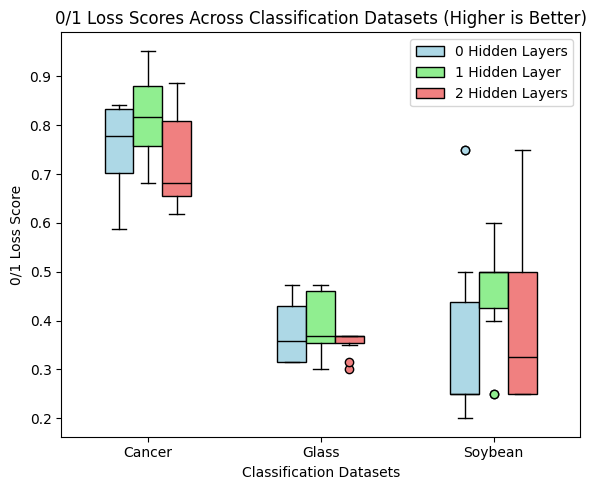

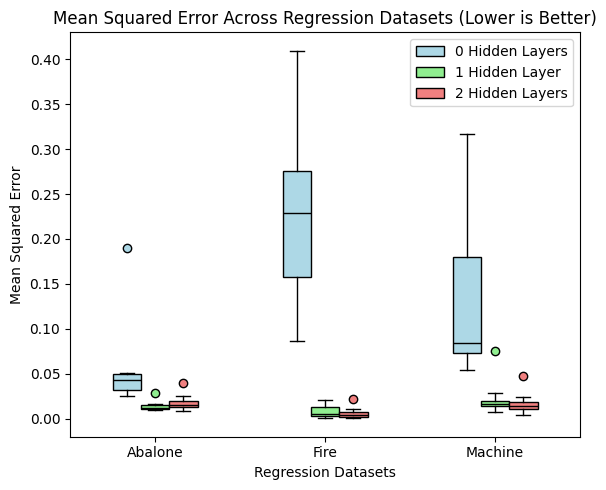

In [40]:
classification_arrays = [cancer_GA_0_score,cancer_GA_1_score,cancer_GA_2_score,
                         glass_GA_0_score,glass_GA_1_score,glass_GA_2_score,
                         soybean_GA_0_score,soybean_GA_1_score,soybean_GA_2_score]
regression_arrays = [abalone_GA_0_score,abalone_GA_1_score,abalone_GA_2_score,
                     fire_GA_0_score,fire_GA_1_score,fire_GA_2_score,
                     machine_GA_0_score,machine_GA_1_score,machine_GA_2_score]
arrays_to_save = []
arrays_to_save.extend(classification_arrays)
arrays_to_save.extend(regression_arrays)
#print(arrays_to_save)
save_arrays_to_csv(arrays_to_save, 'GA_Data.csv')
loaded_arrays = load_arrays_from_csv('GA_Data.csv')
#loaded_arrays[1] = cancer_1_score
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
#loaded_arrays = classification_arrays
#loaded_arrays.extend(regression_arrays)
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']

make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (6, 5), 0, '/home/carlthedog3/CSCI_447/Project_4/Code/Figures/')

## DE Plots

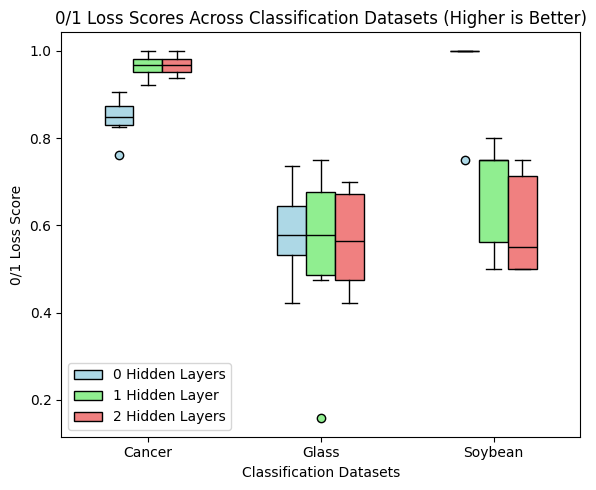

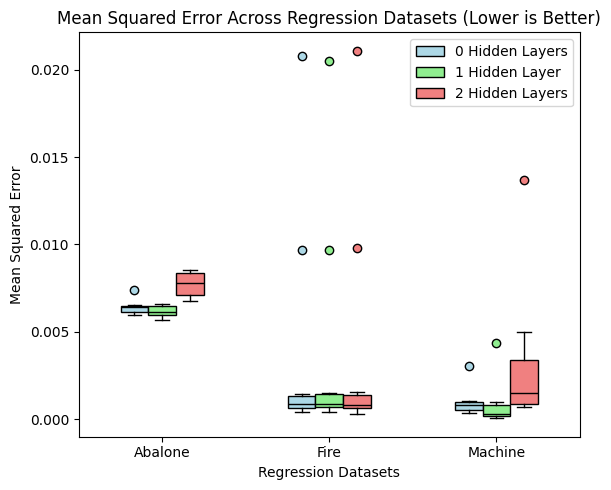

In [ ]:
classification_arrays = [cancer_DE_0_score,cancer_DE_1_score,cancer_DE_2_score,
                         glass_DE_0_score,glass_DE_1_score,glass_DE_2_score,
                         soybean_DE_0_score,soybean_DE_1_score,soybean_DE_2_score]
regression_arrays = [abalone_DE_0_score,abalone_DE_1_score,abalone_DE_2_score,
                     fire_DE_0_score,fire_DE_1_score,fire_DE_2_score,
                     machine_DE_0_score,machine_DE_1_score,machine_DE_2_score]
arrays_to_save = []
arrays_to_save.extend(classification_arrays)
arrays_to_save.extend(regression_arrays)
#print(arrays_to_save)
save_arrays_to_csv(arrays_to_save, 'DE_Data.csv')
loaded_arrays = load_arrays_from_csv('DE_Data.csv')
#loaded_arrays[1] = cancer_1_score
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
#loaded_arrays = classification_arrays
#loaded_arrays.extend(regression_arrays)
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']

make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (6, 5), 0, '/home/carlthedog3/CSCI_447/Project_4/Code/Figures/')

In [ ]:
'''
#classification_arrays = [cancer_0_score,cancer_1_score,cancer_2_score,
#                         glass_0_score,glass_1_score,glass_2_score,
#                         soybean_0_score,soybean_1_score,soybean_2_score]
#regression_arrays = [abalone_0_score,abalone_1_score,abalone_2_score,
#                     fire_0_score,fire_1_score,fire_2_score,
#                     machine_0_score,machine_1_score,machine_2_score]
#arrays_to_save = []
#arrays_to_save.extend(classification_arrays)
#arrays_to_save.extend(regression_arrays)
#print(arrays_to_save)
#save_arrays_to_csv(arrays_to_save, 'results.csv')
loaded_arrays = load_arrays_from_csv('results.csv')
#loaded_arrays[1] = cancer_1_score
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
#loaded_arrays = classification_arrays
#loaded_arrays.extend(regression_arrays)
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']

make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (6, 5), 0, '/home/carlthedog3/CSCI_447/Project_3/Code/Figures/')
'''

In [ ]:
'''
cancer_DE_1.init_population(100)
print(f"Population Set Datatype:\n{type(cancer_DE_1.population)}")
print(f"Weight Set Datatype:\n{type(cancer_DE_1.population[0][0])}")
print(f"Single Candidate:\n{cancer_DE_1.population[0]}")
print(f"Single Candidate's Weights:\n{cancer_DE_1.population[0][0]}")
print(f"Single Candidate's Biases:\n{cancer_DE_1.population[0][1]}")
'''